Analysis on wav files. Exploring packages and wav files - fourier transforms, Mel Frequency Cepstral Coefficients, spectral analysis, and extracting features.

# Exploring a few wavs

In [1]:
import wave
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
from scipy.fftpack import fft
import pandas as pd
%matplotlib inline

In [2]:
chirp = wave.open(os.path.abspath('bird_audio/A_rate_only/wav/wav_A-bird1/toddIII-T_T1bTarMaj2.wav'))

In [3]:
chirp.getparams()

(1, 2, 44100, 1067904, 'NONE', 'not compressed')

In [4]:
signal = chirp.readframes(-1)
signal = np.fromstring(signal, 'Int16')
signal = signal/(2.**15)
# signal = signal/max(signal)
fs = chirp.getframerate()
time = np.linspace(0, len(signal)/fs, num=len(signal))

In [5]:
max(signal)

0.84539794921875

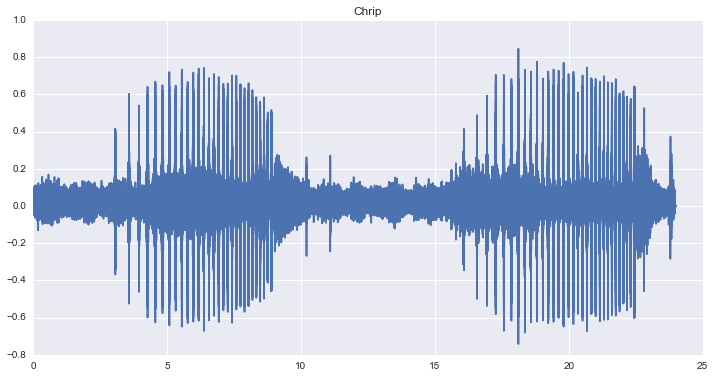

In [6]:
plt.figure(figsize=(12,6))
plt.title('Chrip')
plt.plot(time,signal)
plt.show()

# Using Scipy

In [7]:
sampFreq, snd = wavfile.read('bird_audio/A_rate_only/wav/wav_A-bird1/toddIII-T_T1bTarMaj2.wav')
assert snd.dtype == 'int16'

In [8]:
# normalization for 16-bit wave

snd = snd/(2.**15)
snd = snd/max(snd)

In [9]:
snd.shape

(1067904,)

In [10]:
snd.shape[0]/sampFreq

24

In [11]:
snd.shape[0]

1067904

In [12]:
# make sure we only choose one track on the wav file
# this example is one channel so we don't have to worry

In [13]:
timeArray = np.linspace(0, len(snd)/sampFreq, len(snd))

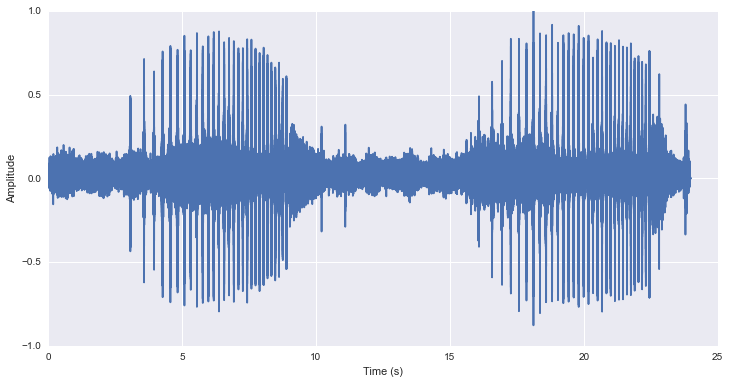

In [14]:
plt.figure(figsize=(12,6))
plt.plot(timeArray, snd)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

# Generate wav dictionary to work with

In [15]:
# generate wav list

bird_dict = {}
for root, dirs, files in os.walk(os.path.abspath('bird_audio/A_rate_only/wav')):
    files = [f for f in files if not f[0] == '.']
    dirs[:] = [d for d in dirs if not d[0] == '.']
    bird_dict[root[-5:]] = [root + '/' + f for f in files]

# Let's make this a function

In [16]:
# takes in a list of wav_files. creats time vs. amplitude graph.

# returns dictionary formatted as key = wav_file, value = (sampFreq, timeArray, data)

def wav_plot(wav_list):
    wav_dict = {}
    for wav in wav_list:
        sampFreq, snd = wavfile.read(wav)
        try:
            if len(snd[0]) == 2:
                snd = snd[:,0]
        except:
            dummy = 0
        if snd.dtype == 'int16':
            norm_factor = 15
        if snd.dtype == 'int8':
            norm_factor = 7
        snd = snd/(2.**norm_factor)
        snd = snd/max(snd)
        timeArray = np.linspace(0, len(snd)/float(sampFreq), len(snd))
        wav_dict[wav] = (sampFreq, timeArray, snd)
        plt.figure(figsize=(12,6))
        plt.plot(timeArray, snd)
        plt.ylabel('Amplitude')
        plt.xlabel('Time (s)')
    return wav_dict

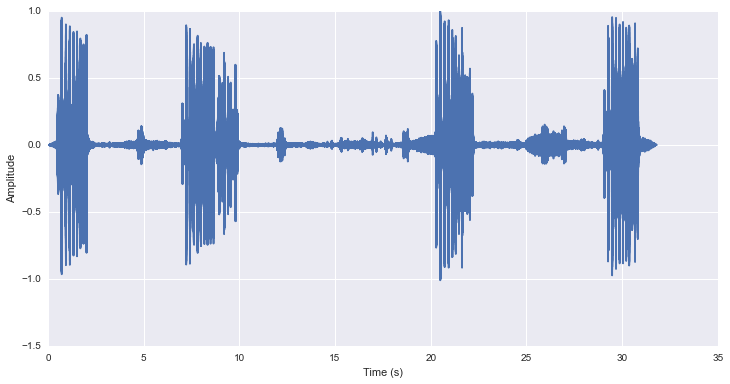

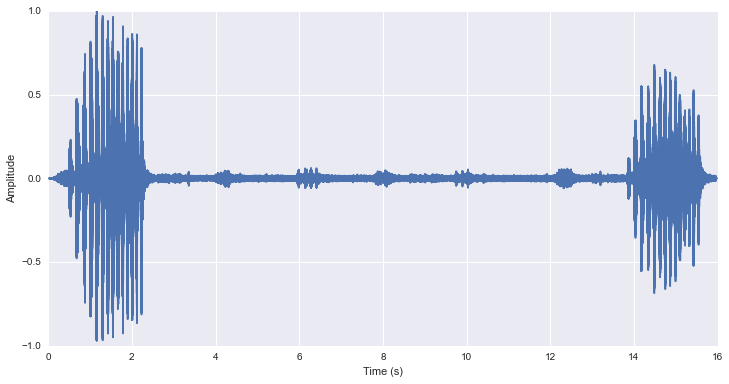

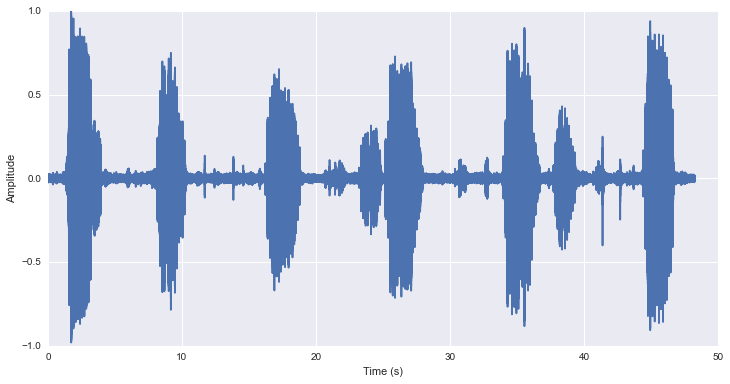

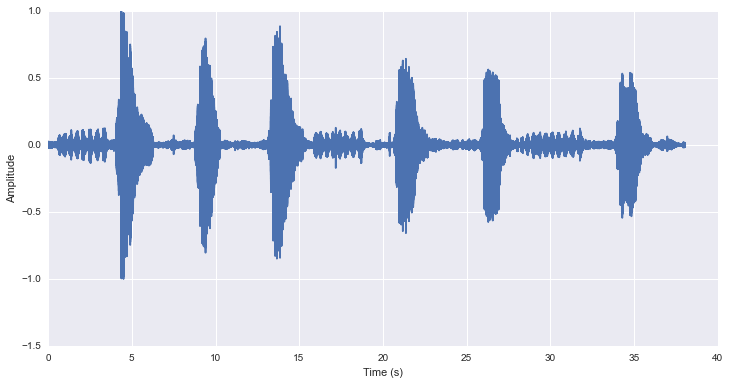

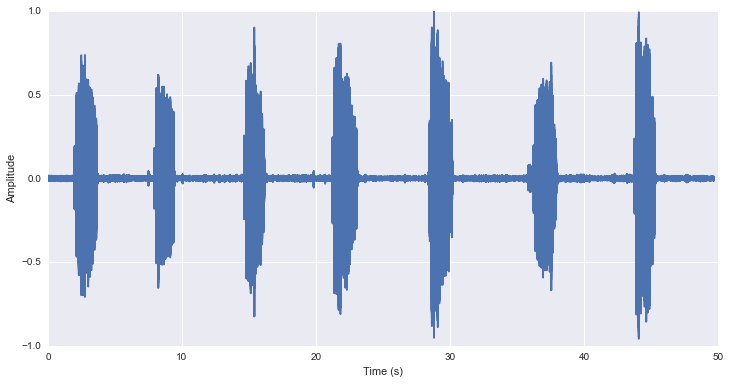

In [17]:
wav_dict = wav_plot(bird_dict['bird0'][:5])

# Fourier Transform

In [18]:
# frequency
n = len(snd)
uniqObs = int(math.ceil((n+1)/2))
k = np.arange(n)
T = n/float(sampFreq)
freqArray1 = k/T
freqArray1 = freqArray1[range(uniqObs)]

In [19]:
snd_ft = fft(snd)
print snd_ft
snd_ft = snd_ft/float(n)
snd_ft = abs(snd_ft)
snd_ft = snd_ft[range(uniqObs)]

[ 26067.62836618 +0.j            -60.94409971 +5.45883489j
    -93.79092697 -4.56777211j ...,    -77.42615047-15.27510979j
    -93.79092697 +4.56777211j    -60.94409971 -5.45883489j]


In [20]:
# testing padding with zero to assist in fft calculation

zeropadded = fft(snd, n=2**(math.ceil(math.log(len(snd),2))+1))
print zeropadded
n = len(zeropadded)
uniqObs = int(math.ceil((n+1)/2))
k = np.arange(n)
T = n/float(sampFreq)
freqArray2 = k/T
freqArray2 = freqArray2[range(uniqObs)]
zeropadded = zeropadded
zeropadded = abs(zeropadded)
zeropadded = zeropadded[range(uniqObs)]

[ 26067.62836618    +0.j          16294.30929056-16779.85491437j
   -480.42897744-16325.86264972j ...,  -5466.08511070 +5000.44542445j
   -480.42897744+16325.86264972j  16294.30929056+16779.85491437j]


/Users/kzecchini/anaconda/lib/python2.7/site-packages/scipy/fftpack/basic.py:150: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  z = zeros(s,x.dtype.char)


In [21]:
print len(freqArray2)
print len(freqArray1)
freq_test = filter(lambda x: x >= 1, freqArray2)
value_test = zeropadded[-len(freq_test):]

print math.ceil(len(freqArray2)/float(len(freqArray1)))

2097152
533952
4.0


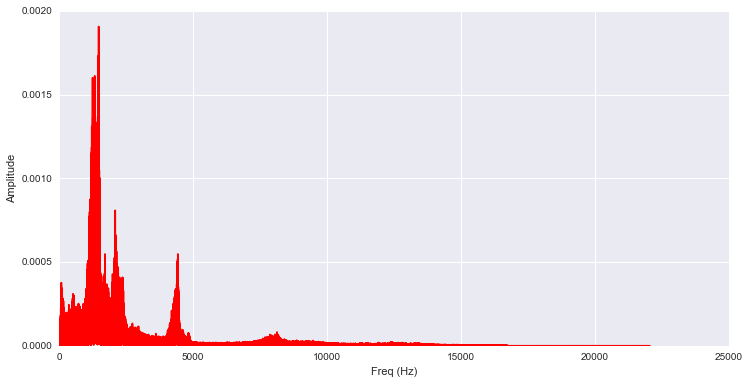

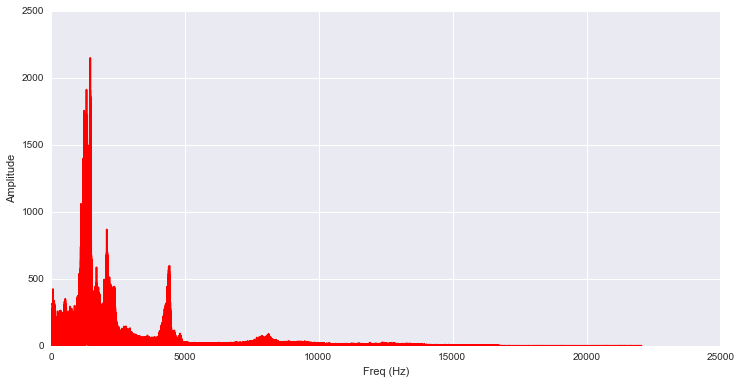

In [22]:
plt.figure(figsize=(12,6))
plt.plot(freqArray1[1:], snd_ft[1:], 'r')
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')

plt.figure(figsize=(12,6))
plt.plot(freq_test, value_test, 'r')
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')


In [23]:
# Let's make this a function

def fourier_trans(wav_data_dict):
    fourier_dict = {}
    for key, (sampFreq, timeArray, snd) in wav_data_dict.iteritems():
        n = len(snd)
        uniqObs = int(math.ceil((n+1)/2))
        k = np.arange(n)
        T = n/float(sampFreq)
        freqArray = k/T
        freqArray = freqArray[range(uniqObs)]
        snd_ft = fft(snd)
        snd_ft = snd_ft/float(n)
        snd_ft = abs(snd_ft)
        snd_ft = snd_ft[range(uniqObs)]
        fourier_dict[key] = (sampFreq, timeArray, snd, snd_ft)
        plt.figure(figsize=(12,6))
        plt.plot(freqArray, snd_ft, 'r')
        plt.xlabel('Freq (Hz)')
        plt.ylabel('Amplitude')
    return fourier_dict
        

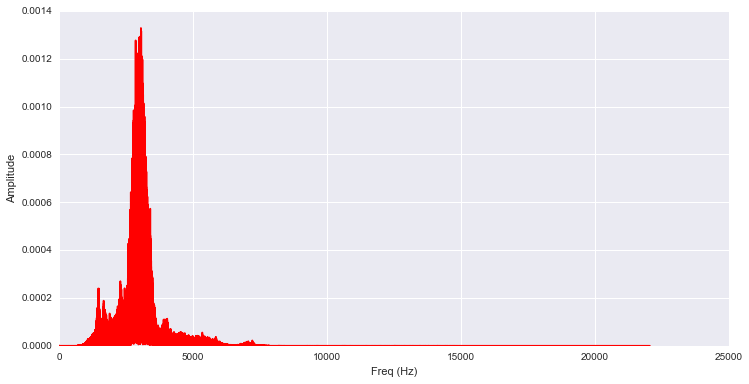

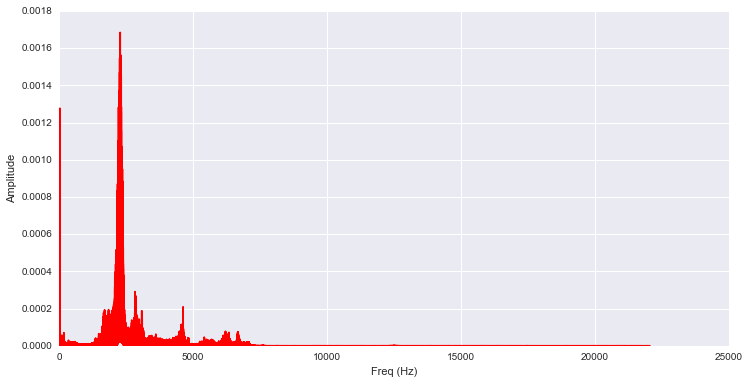

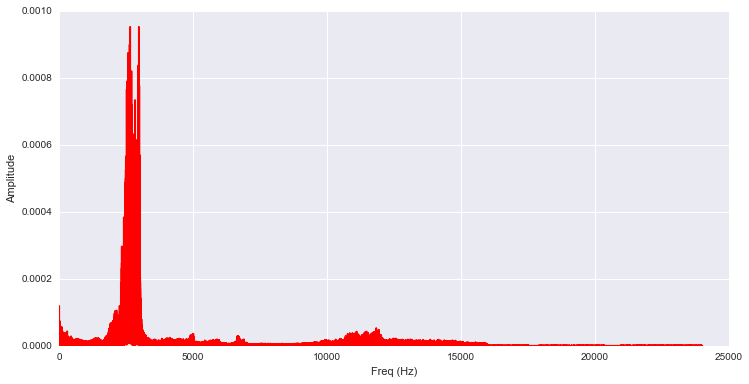

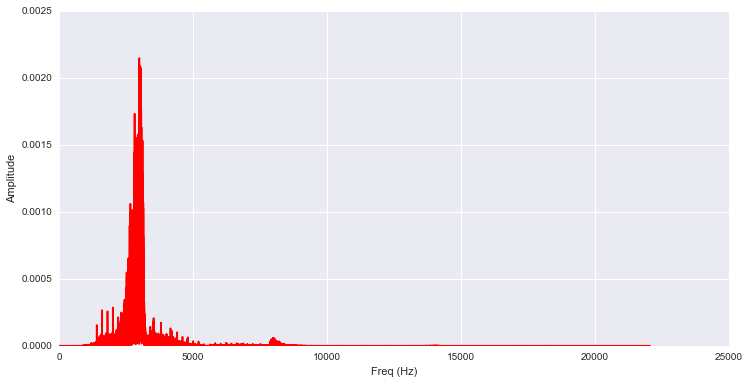

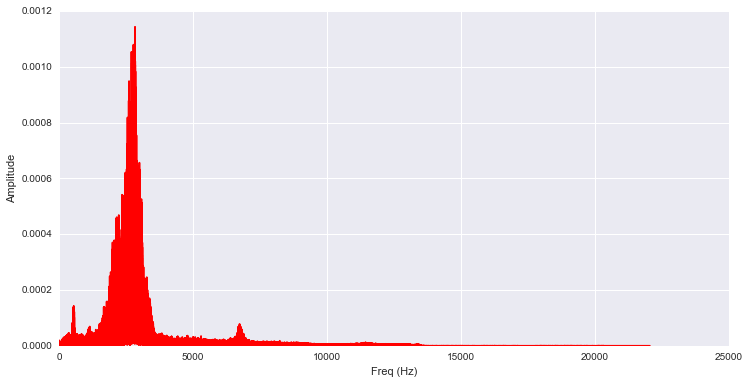

In [24]:
fourier_dict = fourier_trans(wav_dict)

# Plot against power

In [25]:
power = snd_ft**2

if n % 2 > 0:
    power[1:len(power)] = power[1:len(power)]*2
else:
    power[1:len(power)-1] = power[1:len(power)-1]*2

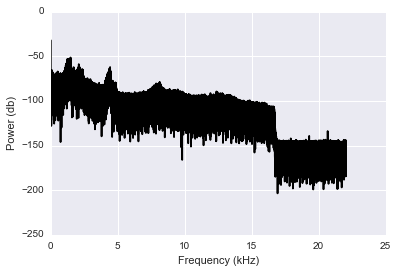

In [26]:
plt.plot(freqArray1/1000, 10*np.log10(power), color='k')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (db)')

In [27]:
# ensuring the calculation is correct

np.sqrt(np.mean(snd**2))

0.08318276330974847

In [28]:
np.sqrt(sum(power))

0.083182763309182214

# Making Better Functions

In [29]:
# Need a way to visualize single wav graphs

def single_wav(wav):
    sampFreq, snd = wavfile.read(wav)
    try:
        if len(snd[0]) == 2:
            snd = snd[:,0]
    except:
        dummy = 0
    if snd.dtype == 'int16':
        norm_factor = 15
    if snd.dtype == 'int8':
        norm_factor = 7
    snd_new = snd/(2.**norm_factor)
    snd_new = snd_new/max(snd_new)
    timeArray = np.linspace(0, len(snd_new)/float(sampFreq), len(snd_new))
    # Comment out plotting - we just need the numerical values
#     plt.figure(figsize=(12,10))
#     plt.plot(timeArray, snd_new)
#     plt.ylabel('Amplitude')
#     plt.xlabel('Time (s)')
#     plt.ylim([-1.1, 1.1])
    return sampFreq, timeArray, snd_new, snd

In [30]:
def single_ft(sampFreq, timeArray, snd):
    snd_ft = fft(snd, n=2**(math.ceil(math.log(len(snd),2))+1))
    n_ft = len(snd_ft)
    uniqObs = int(math.ceil((n_ft+1)/2))
    k_ft = np.arange(n_ft)
    T_ft = n_ft/float(sampFreq)
    freqArray_ft = k_ft/T_ft
    freqArray_ft = freqArray_ft[range(uniqObs)]
    snd_ft = snd_ft/float(n_ft)
    snd_ft = abs(snd_ft)
    snd_ft = snd_ft[range(uniqObs)]
    snd_ft = snd_ft/max(snd_ft)
    new_freqArray_ft = filter(lambda x: x >= 100, freqArray_ft)
    new_snd_ft = snd_ft[-len(new_freqArray_ft):]
        
    zipped = zip(new_snd_ft, new_freqArray_ft)
    max_amp, max_freq = max(zipped)
    
    # we don't really need the rolling max right now
    # roll_max = rolling_max(new_snd_ft, 2000)
    
    # Comment out plotting - only need numerical values
#     plt.figure(figsize=(12,10))
#     plt.plot(new_freqArray_ft, new_snd_ft, 'r')
#     plt.plot(new_freqArray_ft, roll_max, 'b')
#     plt.xlabel('Freq (Hz)')
#     plt.ylabel('Amplitude')
#     plt.xlim([0, 16000])

    return max_freq, new_snd_ft, new_freqArray_ft

In [31]:
def single_power(snd_ft, freqArray):
    power = snd_ft**2
    if n % 2 > 0:
        power[1:len(power)] = power[1:len(power)]*2
    else:
        power[1:len(power)-1] = power[1:len(power)-1]*2
        
    # Comment out plotting - only need numerical values
#     plt.figure(figsize=(12,10))
#     plt.plot(np.log10(np.array(freqArray)/1000), 10*np.log10(power), color='k')
#     plt.xlabel('Frequency (kHz)')
#     plt.ylabel('Power (db)')
    return power

Upon inspecting the fourier graph, I thought it may be useful to have a smoothing element, or calculate the rolling maximum in order to smooth the curve. This didn't really prove to be useful, but I kept the code in anyway since I thought it was interesting.

In [32]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [33]:
def rolling_max(y, box_pts):
    y = pd.Series(y)
    roll_max = pd.stats.moments.rolling_apply(y, box_pts, max)
    return roll_max

# Calculating Features

In [34]:
from scipy.stats import binned_statistic
import librosa

# result dict
def calculate_features(wav_file, bird, sr, norm_snd, freqs_fft, snd_fft):
    result = [wav_file.split('/')[-1], bird]
    
    freq_bin_vals = np.arange(0, 16000, 1000)
    amp_bin_vals = np.arange(0, 1.25, 0.25)
    bin_freqs = binned_statistic(freqs_fft, snd_fft, 
                                 bins=freq_bin_vals, 
                                 statistic='mean', 
                                 range=[0, 16000])[0]
    bin_amps_count = binned_statistic(snd_fft, freqs_fft,
                                bins=amp_bin_vals,
                                statistic='count')[0]
    bin_amps_perc = bin_amps_count/len(freqs_fft)
    result.extend(bin_freqs)
    result.extend(bin_amps_perc)
    
    rmse_avg = librosa.feature.rmse(y=norm_snd)[0].mean()
    result.append(rmse_avg)
    
    rmse_all = np.sqrt(np.mean(norm_snd**2))
    result.append(rmse_all)
    
    spec_cent_std = librosa.feature.spectral_centroid(y=norm_snd, sr=sr)[0].std()
    result.append(spec_cent_std)
    
    zero_cross_avg = librosa.feature.zero_crossing_rate(y=norm_snd)[0].mean()
    result.append(zero_cross_avg)
    
    mfcc = librosa.feature.mfcc(y=norm_snd, sr=sr, n_mfcc=13)
    mfcc_avg = []
    for i in range(13):
        mfcc_avg.append(mfcc[:,i].mean())
    result.extend(mfcc_avg)
    
    peak_freq = max(zip(snd_fft, freqs_fft))[1]
    result.append(peak_freq)
    
    return result

/Users/kzecchini/anaconda/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


# Creating Final Feature Table

In [35]:
# this calculates everything!

final = []
for key, value in bird_dict.iteritems():
    for wav in value:
        print key, wav # so we know it is working (might take a while to calculate)
        x, y, z1, z2 = single_wav(wav)
        ft = single_ft(x, y, z1)
        res = calculate_features(wav, key, x, z1, ft[2], ft[1])
        final.append(res)

bird4 /Users/kzecchini/independent_projects/bird_audio_classification/bird_classification/bird_audio/A_rate_only/wav/wav_A-bird4/0225 American Robin.wav
bird4 /Users/kzecchini/independent_projects/bird_audio_classification/bird_classification/bird_audio/A_rate_only/wav/wav_A-bird4/20100616-0715-DREW1084-US-CA-SIerra-Yuba Pass-American Robin songs_1.wav
bird4 /Users/kzecchini/independent_projects/bird_audio_classification/bird_classification/bird_audio/A_rate_only/wav/wav_A-bird4/20100616-0715-DREW1084-US-CA-SIerra-Yuba Pass-American Robin songs_2.wav
bird4 /Users/kzecchini/independent_projects/bird_audio_classification/bird_classification/bird_audio/A_rate_only/wav/wav_A-bird4/American Robin2011-5-26-1.wav
bird4 /Users/kzecchini/independent_projects/bird_audio_classification/bird_classification/bird_audio/A_rate_only/wav/wav_A-bird4/AmericanRobin2.wav
bird4 /Users/kzecchini/independent_projects/bird_audio_classification/bird_classification/bird_audio/A_rate_only/wav/wav_A-bird4/America

### Creating table and pickle

In [41]:
columns = ['wav', 
           'bird', 
           '1 kHz', 
           '2 kHz',
           '3 kHz',
           '4 kHz',
           '5 kHz',
           '6 kHz',
           '7 kHz',
           '8 kHz',
           '9 kHz',
           '10 kHz',
           '11 kHz',
           '12 kHz',
           '13 kHz',
           '14 kHz',
           '15 kHz',
           '25% Amp',
           '50% Amp',
           '75% Amp',
           '100% Amp',
           'RMSE AVG',
           'RMSE ALL',
           'Spec Cent Std.',
           'Zero Cross Avg',
           'MFCC 1',
           'MFCC 2',
           'MFCC 3',
           'MFCC 4',
           'MFCC 5',
           'MFCC 6',
           'MFCC 7',
           'MFCC 8',
           'MFCC 9',
           'MFCC 10',
           'MFCC 11',
           'MFCC 12',
           'MFCC 13',
           'Max Frq. Hz']

In [42]:
df = pd.DataFrame(np.array(final))
df.columns = columns
df.head()

,wav,bird,1 kHz,2 kHz,3 kHz,4 kHz,5 kHz,6 kHz,7 kHz,8 kHz,...,MFCC 5,MFCC 6,MFCC 7,MFCC 8,MFCC 9,MFCC 10,MFCC 11,MFCC 12,MFCC 13,Max Frq. Hz
0,0225 American Robin.wav,bird4,0.00660811337607,0.00586052709567,0.114964782126,0.0447805974047,0.00338685235494,0.000903604240303,0.000830894963305,0.000684011153386,...,-32.035849844,-32.6002993345,-32.3846143193,-31.2138321206,-31.0443985972,-31.7698419527,-34.1987718029,-32.8585805204,-32.4790001388,2791.19939804
1,20100616-0715-DREW1084-US-CA-SIerra-Yuba Pass-...,bird4,0.00303052147582,0.00180709906578,0.0767300097198,0.0203860302409,0.00501422174475,0.00216170303658,0.000885244763049,0.000813158948617,...,-10.800402514,-10.8371940576,-12.4238394539,-8.31852289835,-7.35538114801,-9.12617747973,-12.8096573365,-13.7758559916,-13.5522468673,2654.26540375
2,20100616-0715-DREW1084-US-CA-SIerra-Yuba Pass-...,bird4,0.0026542594461,0.00190433208335,0.083328789534,0.0228187588581,0.0044124784794,0.00155856531937,0.000963062984715,0.00089685600878,...,-9.802308158,-11.2587251851,-12.2084366139,-13.7176464205,-12.0282096711,-12.4146472858,-11.310868484,-12.0142006754,-14.3785565767,2699.43237305
3,American Robin2011-5-26-1.wav,bird4,0.00364826030215,0.0280566702363,0.19708527077,0.138327212499,0.106067529007,0.0930323410934,0.141180400206,0.0907608752329,...,-28.1384569357,-26.0265825772,-28.0376316297,-29.3626388869,-30.5180233899,-31.3250014385,-29.8422178177,-30.7707380243,-31.1605729096,2765.35892487
4,AmericanRobin2.wav,bird4,0.00410372242442,0.0113336155918,0.0849610471753,0.148842569192,0.0508337411103,0.0297377597695,0.0128532109995,0.0062949810503,...,-40.0275450104,-39.4573350638,-40.1286220575,-40.8308214538,-40.9981361101,-40.9944714751,-40.3474120285,-40.0149242049,-39.9993980443,3059.58366394


In [43]:
import pickle
with open('df_6birds.pkl', 'w') as picklefile:
    pickle.dump(df, picklefile)

In [ ]:
# Extra Utilities to play with - adapted code

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)    
    
""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))
    
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,scale[i]:], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,scale[i]:scale[i+1]], axis=1)
    
    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]
    
    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    
    timebins, freqbins = np.shape(ims)
    
    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()
        
    plt.clf()

plotstft(bird_dict['bird0'][3])

In [ ]:
def peakdetect(y_axis, x_axis = None, lookahead = 300, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maximas and minmias in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maximas and minimas respectively
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    lookahead -- (optional) distance to look ahead from a peak candidate to
        determine if it is the actual peak (default: 200) 
        '(sample / period) / f' where '4 >= f >= 1.25' might be a good value
    delta -- (optional) this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            delta function causes a 20% decrease in speed, when omitted
            Correctly used it can double the speed of the function
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    #x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError, "Lookahead must be '1' or above in value"
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError, "delta must be a positive number"
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]